In [1]:
import os
import gc
import sys
import vote
import time
import random
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.io as pio
from maverick import Maverick
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from collections import Counter
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix

2025-01-19 23:15:15.620044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 23:15:15.714097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 23:15:15.716963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 23:15:16.839788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
%load_ext memory_profiler

In [6]:
repo_dir = "can-fd"
if not os.path.exists("../can-fd"):
    !git clone https://github.com/val-co/can-fd

DATASET_DIRECTORY = '/home/ubuntu/Maverick/' + repo_dir + '/'

In [5]:
%%script echo skipping

csv_files = [file for file in os.listdir(DATASET_DIRECTORY) if file.endswith('.csv')]

X_list = []
y_list = []

dataframes = {}

for file in csv_files:
    file_path = os.path.join(DATASET_DIRECTORY, file)
    df = pd.read_csv(file_path)
    X_list.append(df.iloc[:, :-1])  # Append all columns except the last one (features)
    y_list.append(df.iloc[:, -1])   # Append only the last column (labels)
    
# Concatenate all DataFrames along the rows to create X (features)
X = pd.concat(X_list, ignore_index=True)

# Concatenate all Series (labels) along the rows to create y
y = pd.concat(y_list, ignore_index=True)

print(X.shape, Counter(y))

with open("X_fd.pkl", 'wb') as f1:
    pickle.dump(X, f1)
    
with open("y_fd.pkl", 'wb') as f2:
    pickle.dump(y, f2)

skipping


In [8]:
[file for file in os.listdir(DATASET_DIRECTORY) if file.endswith('.csv')]

['processed_CANFD_Flooding.csv',
 'processed_CANFD_Malfunction.csv',
 'processed_CANFD_Fuzzing.csv']

In [9]:
with open("../Baseline Experiments/X_fd.pkl", 'rb') as f1:
    X = pickle.load(f1)
    
with open("../Baseline Experiments/y_fd.pkl", 'rb') as f2:
    y = pickle.load(f2)
    
print(X.shape, Counter(y))

(7120602, 66) Counter({0: 5490129, 1: 1630473})


In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd

def create_5folds(X, y, random_state=42):
    X_folds, y_folds = {}, {}
    X_train, X_surrogate, X_test = {}, {}, {}
    y_train, y_surrogate, y_test = {}, {}, {}
    
    # First split: 80/20
    X_80, X_folds[0], y_80, y_folds[0] = train_test_split(X, y, 
        test_size=0.2, random_state=random_state, shuffle=True,)
    
    # Split 80 into 40/40
    X_40_1, X_40_2, y_40_1, y_40_2 = train_test_split(X_80, y_80, 
        test_size=0.5, random_state=random_state, shuffle=True,)
    
    # Split first 40 into 20/20
    X_folds[1], X_folds[2], y_folds[1], y_folds[2] = train_test_split(X_40_1, y_40_1, 
        test_size=0.5, random_state=random_state, shuffle=True,)
    
    # Split second 40 into 20/20
    X_folds[3], X_folds[4], y_folds[3], y_folds[4] = train_test_split(X_40_2, y_40_2, 
        test_size=0.5, random_state=random_state, shuffle=True,)
    
    fold_indices = {0, 1, 2, 3, 4}
    
    for fold in range(5):
        test_fold = fold
        surrogate_fold = (fold + 1) % 5
        train_fold = fold_indices - {surrogate_fold, test_fold}
        X_test[fold], y_test[fold] = X_folds[test_fold], y_folds[test_fold]
        X_surrogate[fold], y_surrogate[fold] = X_folds[surrogate_fold], y_folds[surrogate_fold]
        X_train[fold], y_train[fold] = pd.concat([X_folds[i] for i in train_fold]), pd.concat([y_folds[i] for i in train_fold])

    del X_folds, y_folds
    return X_train, y_train, X_surrogate, y_surrogate, X_test, y_test

In [9]:
X_train, y_train, X_surrogate, y_surrogate, X_test, y_test = create_5folds(X, y)

In [10]:
del X, y
gc.collect()

22

In [11]:
for fold in range(5):
    X_train[fold].columns = [col.replace('[', '(').replace(']', ')') for col in X_train[fold].columns]
    X_surrogate[fold].columns = [col.replace('[', '(').replace(']', ')') for col in X_surrogate[fold].columns]
    X_test[fold].columns = [col.replace('[', '(').replace(']', ')') for col in X_test[fold].columns]

In [12]:
import joblib
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth': 10,  # Maximum depth of each tree
    'n_estimators': 254,  # Number of trees
    'seed': 42,  # Random seed
}

Path("models").mkdir(exist_ok=True)

if not Path("models/xgb_model_fold_0.joblib").exists():
    model0 = XGBClassifier(**params)
    model0.fit(X_train[0], y_train[0])
    print("Model-0 Trained")
    joblib.dump(model0, "models/xgb_model_fold_0.joblib")

if not Path("models/xgb_model_fold_1.joblib").exists():
    model1 = XGBClassifier(**params)
    model1.fit(X_train[1], y_train[1])
    print("Model-1 Trained")
    joblib.dump(model1, "models/xgb_model_fold_1.joblib")

if not Path("models/xgb_model_fold_2.joblib").exists():
    model2 = XGBClassifier(**params)
    model2.fit(X_train[2], y_train[2])
    print("Model-2 Trained")
    joblib.dump(model2, "models/xgb_model_fold_2.joblib")

if not Path("models/xgb_model_fold_3.joblib").exists():
    model3 = XGBClassifier(**params)
    model3.fit(X_train[3], y_train[3])
    print("Model-3 Trained")
    joblib.dump(model3, "models/xgb_model_fold_3.joblib")

if not Path("models/xgb_model_fold_4.joblib").exists():
    model4 = XGBClassifier(**params)
    model4.fit(X_train[4], y_train[4])
    print("Model-4 Trained")
    joblib.dump(model4, "models/xgb_model_fold_4.joblib")

model0 = joblib.load("models/xgb_model_fold_0.joblib")
model1 = joblib.load("models/xgb_model_fold_1.joblib")
model2 = joblib.load("models/xgb_model_fold_2.joblib")
model3 = joblib.load("models/xgb_model_fold_3.joblib")
model4 = joblib.load("models/xgb_model_fold_4.joblib")
print("Loaded Models")

Loaded Models


In [13]:
import xgboost as xgb

if isinstance(model0, xgb.XGBClassifier):
    booster = model0.get_booster()  # Access the Booster object
    trees = booster.get_dump()  # Get the trees as text
    max_leaves = 0
    for tree in trees:
        leaves = tree.count('leaf')
        max_leaves = max(max_leaves, leaves)
    print(f"Maximum number of leaves (Model-0): {max_leaves}")
    
if isinstance(model1, xgb.XGBClassifier):
    booster = model1.get_booster()  # Access the Booster object
    trees = booster.get_dump()  # Get the trees as text
    max_leaves = 0
    for tree in trees:
        leaves = tree.count('leaf')
        max_leaves = max(max_leaves, leaves)
    print(f"Maximum number of leaves (Model-1): {max_leaves}")
    
if isinstance(model2, xgb.XGBClassifier):
    booster = model2.get_booster()  # Access the Booster object
    trees = booster.get_dump()  # Get the trees as text
    max_leaves = 0
    for tree in trees:
        leaves = tree.count('leaf')
        max_leaves = max(max_leaves, leaves)
    print(f"Maximum number of leaves (Model-2): {max_leaves}")
    
if isinstance(model3, xgb.XGBClassifier):
    booster = model3.get_booster()  # Access the Booster object
    trees = booster.get_dump()  # Get the trees as text
    max_leaves = 0
    for tree in trees:
        leaves = tree.count('leaf')
        max_leaves = max(max_leaves, leaves)
    print(f"Maximum number of leaves (Model-3): {max_leaves}")
    
if isinstance(model4, xgb.XGBClassifier):
    booster = model4.get_booster()  # Access the Booster object
    trees = booster.get_dump()  # Get the trees as text
    max_leaves = 0
    for tree in trees:
        leaves = tree.count('leaf')
        max_leaves = max(max_leaves, leaves)
    print(f"Maximum number of leaves (Model-4): {max_leaves}")

Maximum number of leaves (Model-0): 44
Maximum number of leaves (Model-1): 45
Maximum number of leaves (Model-2): 46
Maximum number of leaves (Model-3): 45
Maximum number of leaves (Model-4): 43


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# Create lists to store metrics for each model
metrics = []

# Calculate metrics for each model
for i in range(5):
    model = eval(f"model{i}")
    ypred = model.predict(X_test[i])
    
    # Calculate accuracy
    acc = accuracy_score(ypred, y_test[i])
    
    # Calculate confusion matrix metrics
    tn, fp, fn, tp = confusion_matrix(ypred, y_test[i]).ravel()
    tpr = tp / (tp + fn)  # True positive rate
    tnr = tn / (tn + fp)  # True negative rate
    fpr = fp / (fp + tn)  # False positive rate
    fnr = fn / (fn + tp)  # False negative rate
    
    # Store metrics
    metrics.append({
        'Model': f'Model-{i}',
        'Accuracy': f'{acc:.3f}',
        'TPR': f'{tpr:.3f}',
        'TNR': f'{tnr:.3f}',
        'FPR': f'{fpr:.3f}',
        'FNR': f'{fnr:.3f}'
    })

# Create DataFrame and display
df_metrics = pd.DataFrame(metrics)
print("\nModel Performance Metrics:")
print("=" * 80)
print(df_metrics.to_string(index=False))
print("=" * 80)


Model Performance Metrics:
  Model Accuracy   TPR   TNR   FPR   FNR
Model-0    1.000 1.000 1.000 0.000 0.000
Model-1    1.000 1.000 1.000 0.000 0.000
Model-2    1.000 1.000 1.000 0.000 0.000
Model-3    1.000 1.000 1.000 0.000 0.000
Model-4    1.000 1.000 1.000 0.000 0.000


In [14]:
import joblib
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

Path("surrogates").mkdir(exist_ok=True)

if not Path("surrogates/xgb_surrogate_fold_0.joblib").exists():
    surrogate0 = XGBClassifier(**params)
    surrogate0.fit(X_surrogate[0], y_surrogate[0])
    print("Surrogate-0 Trained")
    joblib.dump(surrogate0, "surrogates/xgb_surrogate_fold_0.joblib")

if not Path("surrogates/xgb_surrogate_fold_1.joblib").exists():
    surrogate1 = XGBClassifier(**params)
    surrogate1.fit(X_surrogate[1], y_surrogate[1])
    print("Surrogate-1 Trained")
    joblib.dump(surrogate1, "surrogates/xgb_surrogate_fold_1.joblib")

if not Path("surrogates/xgb_surrogate_fold_2.joblib").exists():
    surrogate2 = XGBClassifier(**params)
    surrogate2.fit(X_surrogate[2], y_surrogate[2])
    print("Surrogate-2 Trained")
    joblib.dump(surrogate2, "surrogates/xgb_surrogate_fold_2.joblib")

if not Path("surrogates/xgb_surrogate_fold_3.joblib").exists():
    surrogate3 = XGBClassifier(**params)
    surrogate3.fit(X_surrogate[3], y_surrogate[3])
    print("Surrogate-3 Trained")
    joblib.dump(surrogate3, "surrogates/xgb_surrogate_fold_3.joblib")

if not Path("surrogates/xgb_surrogate_fold_4.joblib").exists():
    surrogate4 = XGBClassifier(**params)
    surrogate4.fit(X_surrogate[4], y_surrogate[4])
    print("Surrogate-4 Trained")
    joblib.dump(surrogate4, "surrogates/xgb_surrogate_fold_4.joblib")

surrogate0 = joblib.load("surrogates/xgb_surrogate_fold_0.joblib")
surrogate1 = joblib.load("surrogates/xgb_surrogate_fold_1.joblib")
surrogate2 = joblib.load("surrogates/xgb_surrogate_fold_2.joblib")
surrogate3 = joblib.load("surrogates/xgb_surrogate_fold_3.joblib")
surrogate4 = joblib.load("surrogates/xgb_surrogate_fold_4.joblib")
print("Loaded Surrogates")

Loaded Surrogates


In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# Create lists to store metrics for each model
metrics = []

# Calculate metrics for each model
for i in range(5):
    model = eval(f"surrogate{i}")
    ypred = model.predict(X_test[i])
    
    # Calculate accuracy
    acc = accuracy_score(ypred, y_test[i])
    
    # Calculate confusion matrix metrics
    tn, fp, fn, tp = confusion_matrix(ypred, y_test[i]).ravel()
    tpr = tp / (tp + fn)  # True positive rate
    tnr = tn / (tn + fp)  # True negative rate
    fpr = fp / (fp + tn)  # False positive rate
    fnr = fn / (fn + tp)  # False negative rate
    
    # Store metrics
    metrics.append({
        'Surrogate': f'Surrogate-{i}',
        'Accuracy': f'{acc:.3f}',
        'TPR': f'{tpr:.3f}',
        'TNR': f'{tnr:.3f}',
        'FPR': f'{fpr:.3f}',
        'FNR': f'{fnr:.3f}'
    })

# Create DataFrame and display
df_metrics = pd.DataFrame(metrics)
print("Surrogate Performance Metrics:")
print("=" * 80)
print(df_metrics.to_string(index=False))
print("=" * 80)

Surrogate Performance Metrics:
  Surrogate Accuracy   TPR   TNR   FPR   FNR
Surrogate-0    1.000 1.000 1.000 0.000 0.000
Surrogate-1    1.000 1.000 1.000 0.000 0.000
Surrogate-2    1.000 1.000 1.000 0.000 0.000
Surrogate-3    1.000 1.000 1.000 0.000 0.000
Surrogate-4    1.000 1.000 1.000 0.000 0.000


In [15]:
X_test_filtered = {}
y_test_filtered = {}

for fold in range(5):
    # Filter the surrogate set to only include samples where y_surrogate == 1
    X_test_filtered[fold] = X_test[fold][y_test[fold] == 1]
    y_test_filtered[fold] = y_test[fold][y_test[fold] == 1]
    print(f"Fold", str(fold),"- X_test_filtered shape: ",{X_test_filtered[fold].shape})

Fold 0 - X_test_filtered shape:  {(326523, 66)}
Fold 1 - X_test_filtered shape:  {(326535, 66)}
Fold 2 - X_test_filtered shape:  {(326521, 66)}
Fold 3 - X_test_filtered shape:  {(325729, 66)}
Fold 4 - X_test_filtered shape:  {(325165, 66)}


In [16]:
folder_path = "adversarials"
os.makedirs(folder_path, exist_ok=True)

A_path = os.path.join(folder_path, "A.pkl")
L_path = os.path.join(folder_path, "L.pkl")

A_exists = os.path.exists(A_path)
L_exists = os.path.exists(L_path)

if A_exists and L_exists:
    with open(A_path, "rb") as a_file:
        A = pickle.load(a_file)
    with open(L_path, "rb") as l_file:
        L = pickle.load(l_file)
    print("Loaded Adversarial Examples")
else:
    A, L = {}, {}
    for fold in range(5):
        random.seed(42)
        A[fold], L[fold] = [], []
        def label_checker(expected, mapping):
            return vote.mapping_check_argmax(mapping, expected)
        print('Finding Adversarial Examples for fold ', str(fold))
        model = eval(f"surrogate{fold}")
        ids = eval(f"model{fold}")
        e = vote.Ensemble.from_xgboost(model)
        deltas = [0, 0] + [15] * 64 
        for i in tqdm(range(len(y_test_filtered[fold]))):
            def check_robustness(m):
                o = vote.mapping_check_argmax(m, 1)
                if o == vote.FAIL:
                    center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / 2 for dim in range(m.nb_inputs)]
                    if(ids.predict([center]) != 1):
                        A[fold].append(center)
                        L[fold].append(1)
                return o
            domain = [(max(x - delta, 0), min(65535, x + delta)) if (idx == 0 or idx == 1) else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(X_test_filtered[fold].iloc[i].values, deltas))]
            e.absref(check_robustness, domain)
        print('Adversarial Examples Found: ', len(A[fold]), "\n")

    with open(A_path, "wb") as a_file:
        pickle.dump(A, a_file)

    with open(L_path, "wb") as l_file:
        pickle.dump(L, l_file)

Loaded Adversarial Examples


In [17]:
del X_test_filtered, y_test_filtered, surrogate0, surrogate1, surrogate2, surrogate3, surrogate4 
gc.collect()

0

In [18]:
sum(len(A[fold]) for fold in range(5))

117783

In [19]:
test_set, test_lab = {}, {}
test_lab_sym = {}

for fold in range(5):
    random.seed(42)
    num_samples = len(A[fold])
    selected_indices = random.sample(range(len(X_test[fold])), num_samples)
    X_selected = X_test[fold].iloc[selected_indices].values
    y_selected = y_test[fold].iloc[selected_indices].values
    test_set[fold] = np.concatenate((X_selected, A[fold]))
    test_lab_sym[fold] = np.concatenate((np.zeros(len(y_selected), dtype=bool), np.ones(len(L[fold]), dtype=bool)))
    test_lab[fold] = np.concatenate((y_selected, L[fold]))
    print("Evaluation Samples, Fold ", str(fold), ":", len(test_set[fold]))

Evaluation Samples, Fold  0 : 70696
Evaluation Samples, Fold  1 : 54426
Evaluation Samples, Fold  2 : 54508
Evaluation Samples, Fold  3 : 48886
Evaluation Samples, Fold  4 : 7050


In [20]:
if not os.path.exists("ocscore"):
    !git clone https://github.com/laudv/ocscore.git
%cd ocscore
!pip install cython numpy dtai-veritas
!python3 setup.py build_ext --inplace
!git pull

%cd ..
sys.path.append('/home/ubuntu/Maverick/K-Fold FD-CAN/ocscore') 

/home/ubuntu/Maverick/K-Fold FD-CAN/ocscore
running build_ext
Already up to date.
/home/ubuntu/Maverick/K-Fold FD-CAN


In [22]:
import ocscore
# Get all attributes of the module
module_attributes = dir(ocscore)

# Filter out functions from the attributes
functions = [attr for attr in module_attributes if callable(getattr(ocscore, attr))]

# Print the list of functions
print("List of functions:")
for function in functions:
    print(function)

List of functions:
__pyx_unpickle_Enum
_prep_input
_validate_input
mapids
ocscores
ocscores_topk


In [23]:
idref, idquery = {}, {}

for fold in range(5):
    ids = eval(f"model{fold}")
    ytrain_pred = ids.predict(X_train[fold]) 
    xref_mask = ytrain_pred == y_train[fold]
    xref = X_train[fold][xref_mask]
    dtype = np.uint8
    idref[fold] = ids.apply(xref).astype(dtype)
    test_set[fold] = pd.DataFrame(test_set[fold], columns=X_test[fold].columns)
    idquery[fold] = ids.apply(test_set[fold]).astype(dtype)
    print("Generated Reference and Query Set for Fold ", str(fold))

Generated Reference and Query Set for Fold  0
Generated Reference and Query Set for Fold  1
Generated Reference and Query Set for Fold  2
Generated Reference and Query Set for Fold  3
Generated Reference and Query Set for Fold  4


In [24]:
S = {}
times = {}

Path("ocscore_experiments").mkdir(exist_ok=True)
S_path = Path(f"ocscore_experiments/S.pkl")
T_path = Path(f"ocscore_experiments/times.pkl")

if not (S_path.exists() and T_path.exists()):
    for fold in range(5):
        print("Finding OC-Scores for Fold ", str(fold))
        t1 = time.time()
        S[fold] = ocscore.ocscores(idref[fold], idquery[fold])
        t2 = time.time()
        times[fold] = round(((1000000.0*(t2 - t1))/len(S[fold])), 2)
        print(f"Done, OC-score Average Prediction Time: ", round(((1000000.0*(t2 - t1))/len(S[fold])), 2), "μs", "\n")
    with open(S_path, 'wb') as f:
        pickle.dump(S, f)
    with open(T_path, 'wb') as f:
        pickle.dump(times, f)
else:
    with open(S_path, 'rb') as f:
        S = pickle.load(f)
    with open(T_path, 'rb') as f:
        times = pickle.load(f)
    print("Loaded OC-scores and Times from disk.")      

Finding OC-Scores for Fold  0
Done, OC-score Average Prediction Time:  29736.39 μs 

Finding OC-Scores for Fold  1
Done, OC-score Average Prediction Time:  28976.58 μs 

Finding OC-Scores for Fold  2
Done, OC-score Average Prediction Time:  28077.64 μs 

Finding OC-Scores for Fold  3
Done, OC-score Average Prediction Time:  32004.31 μs 

Finding OC-Scores for Fold  4
Done, OC-score Average Prediction Time:  32461.78 μs 



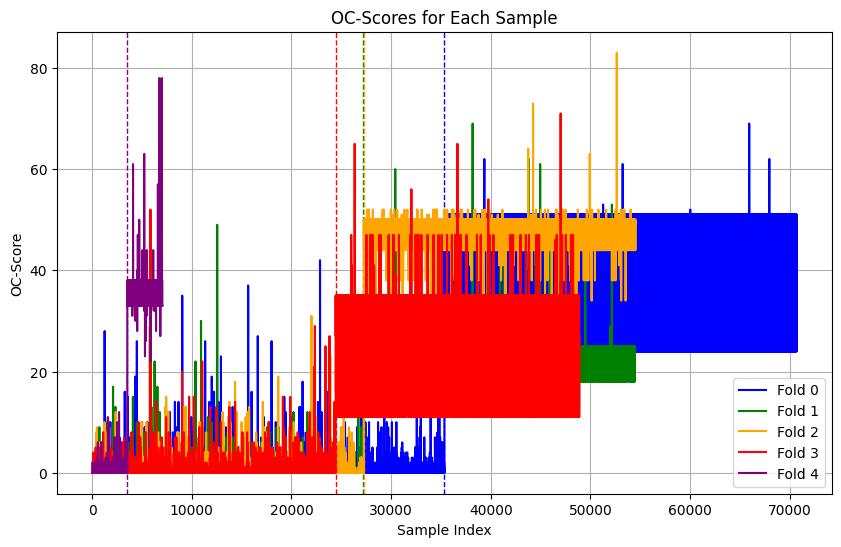

In [25]:
import matplotlib.pyplot as plt
from collections import Counter

colors = ['blue', 'green', 'orange', 'red', 'purple']
plt.figure(figsize=(10, 6))

for fold in range(5):
    plt.plot(S[fold], label=f'Fold {fold}', color=colors[fold], markersize=1)
    plt.axvline(x=Counter(test_lab_sym[fold])[0], color=colors[fold], linestyle='--', linewidth=1)
plt.title('OC-Scores for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('OC-Score')
plt.legend(title="Folds")
plt.grid(True)
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef

threshold = {0:23, 1:17, 2:23, 3:10, 4:23}
results = []

for fold in range(5):
    predictions = []
    ids = eval(f"model{fold}")
    preds = ids.predict(test_set[fold])
    
    for score, pred in zip(S[fold], preds):
        if score <= threshold[fold]:
            predictions.append(pred)
        else:
            predictions.append(abs(1-pred))
    
    acc = round(accuracy_score(predictions, test_lab[fold]), 3)
    f1 = round(f1_score(predictions, test_lab[fold]), 3)
    mcc = round(matthews_corrcoef(predictions, test_lab[fold]), 3)
    auc = round(roc_auc_score(predictions, test_lab[fold]), 3)
    tn, fp, fn, tp = confusion_matrix(predictions, test_lab[fold]).ravel()
    tpr = round(tp / (tp + fn), 3)  # True positive rate
    tnr = round(tn / (tn + fp), 3)  # True negative rate
    fpr = round(fp / (fp + tn), 3)  # False positive rate
    fnr = round(fn / (fn + tp), 3)  # False negative rate

    results.append({
        'Fold': fold, 'Accuracy': acc, 'F1-Score': f1, 'MCC': mcc, 'AUC': auc, 'TPR': tpr, 'TNR': tnr, 'FPR': fpr, 'FNR': fnr
    })
df_results = pd.DataFrame(results)
print(df_results)

   Fold  Accuracy  F1-Score    MCC  AUC  TPR    TNR    FPR  FNR
0     0       1.0       1.0  1.000  1.0  1.0  1.000  0.000  0.0
1     1       1.0       1.0  1.000  1.0  1.0  1.000  0.000  0.0
2     2       1.0       1.0  1.000  1.0  1.0  1.000  0.000  0.0
3     3       1.0       1.0  0.999  1.0  1.0  0.999  0.001  0.0
4     4       1.0       1.0  0.999  1.0  1.0  0.999  0.001  0.0


In [29]:
def convert(number, unit='micro'):
    if unit == 'micro':
        result = number * 1e6
    elif unit == 'milli':
        result = number * 1e3
    elif unit == 'nano':
        result = number * 1e9
    else:
        raise ValueError("Invalid unit. Choose from 'micro', 'milli', or 'nano'.")
    return round(result, 3)

In [30]:
mav = {}
experiments_dir = Path("maverick-experiments")
experiments_dir.mkdir(exist_ok=True)

for fold in range(5):
    ids = eval(f"model{fold}")
    save_filename = experiments_dir / f"autoencoder_fd_{fold}.h5"
    mav[fold] = Maverick(ids, X_train[fold], y_train[fold], save_filename=str(save_filename))

Initializing Maverick...
Training Autoencoder


2025-01-15 07:07:48.037605: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3689610096 exceeds 10% of free system memory.
2025-01-15 07:08:33.504245: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3689610096 exceeds 10% of free system memory.
2025-01-15 07:09:17.058005: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3689610096 exceeds 10% of free system memory.
2025-01-15 07:09:20.186838: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3689610096 exceeds 10% of free system memory.


Epoch 1/50
14184/14186 [============================>.] - ETA: 0s - loss: 0.0315

2025-01-15 07:13:38.681305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 651108680 exceeds 10% of free system memory.


14186/14186 [==============================] - 255s 16ms/step - loss: 0.0315 - val_loss: 0.0219
Epoch 2/50
14186/14186 [==============================] - 212s 15ms/step - loss: 0.0182 - val_loss: 0.0175
Epoch 3/50
14186/14186 [==============================] - 214s 15ms/step - loss: 0.0157 - val_loss: 0.0145
Epoch 4/50
14186/14186 [==============================] - 221s 16ms/step - loss: 0.0141 - val_loss: 0.0176
Epoch 5/50
14186/14186 [==============================] - 215s 15ms/step - loss: 0.0132 - val_loss: 0.0120
Epoch 6/50
14186/14186 [==============================] - 209s 15ms/step - loss: 0.0125 - val_loss: 0.0110
Epoch 7/50
14186/14186 [==============================] - 220s 16ms/step - loss: 0.0118 - val_loss: 0.0125
Epoch 8/50
14186/14186 [==============================] - 221s 16ms/step - loss: 0.0114 - val_loss: 0.0106
Epoch 9/50
14186/14186 [==============================] - 212s 15ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 10/50
14186/14186 [=======================

28/28 [==============================] - 2s 45ms/step


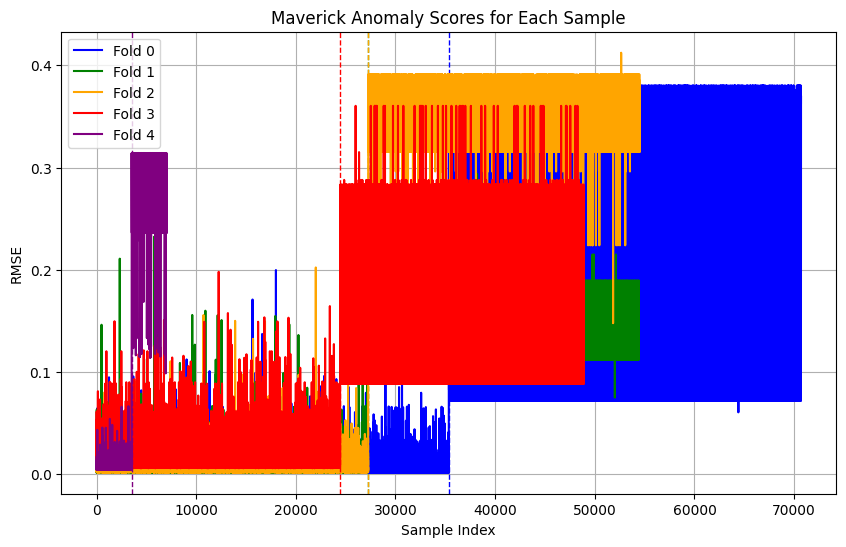

In [31]:
R = {}

for fold in range(5):
    R[fold] = mav[fold].anomaly_scores(test_set[fold])
    
colors = ['blue', 'green', 'orange', 'red', 'purple']
plt.figure(figsize=(10, 6))

for fold in range(5):
    plt.plot(R[fold], label=f'Fold {fold}', color=colors[fold], markersize=1)
    plt.axvline(x=Counter(test_lab_sym[fold])[0], color=colors[fold], linestyle='--', linewidth=1)
plt.title('Maverick Anomaly Scores for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('RMSE')
plt.legend(title="Folds")
plt.grid(True)
plt.legend()
plt.show()

191/191 [==============================] - 1s 6ms/step


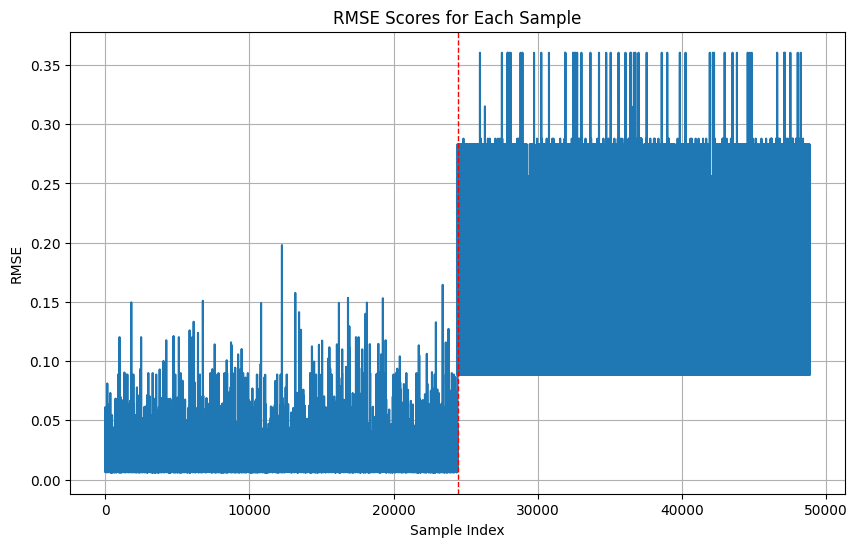

191/191 [==============================] - 1s 5ms/step
0.08832537130175744


In [51]:
index = 3
mav[index].plot_rmse_scores(pd.DataFrame(test_set[index], columns = X_test[index].columns), test_lab_sym[index])
#mav[index].get_roc_curve(pd.DataFrame(test_set[index], columns = X_test[index].columns), test_lab_sym[index])
scores = mav[index].anomaly_scores(pd.DataFrame(test_set[index], columns = X_test[index].columns))
fpr, tpr, thresholds = roc_curve(test_lab_sym[index], scores, pos_label=1)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]
print(threshold)

In [78]:
metrics = []
threshold = {0:0.07, 1:0.11, 2:0.18, 3:0.088, 4:0.09}
columns = ["Fold", "Acc.", "F1-Sc.", "MCC", "AUC", "TPR", "TNR", "FPR", "FNR"]

for fold in range(5):
    predictions = []
    ids = eval(f"model{fold}")
    Rf = mav[fold].anomaly_scores(test_set[fold])
    preds = ids.predict(test_set[fold])
    predictions = np.where(Rf <= threshold[fold], preds, np.abs(1 - preds))  
    accuracy = round(accuracy_score(predictions, test_lab[fold]), 3)
    f1 = round(f1_score(predictions, test_lab[fold]), 3)
    mcc = round(matthews_corrcoef(predictions, test_lab[fold]), 3)
    auc = round(roc_auc_score(predictions, test_lab[fold]), 3)
    tn, fp, fn, tp = confusion_matrix(predictions, test_lab[fold]).ravel()
    tpr = round(tp / (tp + fn), 3)  # True positive rate
    tnr = round(tn / (tn + fp), 3)  # True negative rate
    fpr = round(fp / (fp + tn), 3)  # False positive rate
    fnr = round(fn / (fn + tp), 3)  # False negative rate
    metrics.append([fold, accuracy, f1, mcc, auc, tpr, tnr, fpr, fnr])
metrics_df = pd.DataFrame(metrics, columns=columns)
print(metrics_df)

28/28 [==============================] - 0s 6ms/step
   Fold   Acc.  F1-Sc.    MCC    AUC    TPR    TNR    FPR    FNR
0     0  1.000   1.000  0.999  0.999  1.000  0.999  0.001  0.000
1     1  1.000   1.000  0.999  1.000  1.000  0.999  0.001  0.000
2     2  1.000   1.000  1.000  1.000  1.000  1.000  0.000  0.000
3     3  0.998   0.998  0.995  0.997  0.998  0.997  0.003  0.002
4     4  1.000   1.000  1.000  1.000  1.000  1.000  0.000  0.000


In [85]:
summary = {col: f"{str(metrics_df[col].mean())[:5]} ± {metrics_df[col].std():.3f}" for col in columns[1:]}
summary_df = pd.DataFrame(summary, index=["Summary"]).T
summary_df.columns = ["Value"]
print("\nSummary:")
print(summary_df)


Summary:
                Value
Acc.    0.999 ± 0.001
F1-Sc.  0.999 ± 0.001
MCC     0.998 ± 0.002
AUC     0.999 ± 0.001
TPR     0.999 ± 0.001
TNR     0.999 ± 0.001
FPR     0.001 ± 0.001
FNR     0.000 ± 0.001


In [86]:
raise SystemExit("The bottom timing experiments take too long (30 seconds for Maverick and 6 hours for OC-Score)")

SystemExit: The bottom timing experiments take too long (30 seconds for Maverick and 6 hours for OC-Score)

Maverick: Computing min, max, average and standard deviation!

Finding the fold with the largest test set

In [57]:
test_set = [test_set[0], test_set[1], test_set[2], test_set[3], test_set[4]]
index = np.array([len(item) for item in test_set]).argmax()
print("Fold ID:", index)

Fold ID: 0


In [58]:
times = []

for _ in range(10):
    start_time = time.time()
    y_pred = mav[index].predict(test_set[index], threshold=0.09)
    end_time = time.time()
    times.append(convert((end_time - start_time)/len(test_set[index])))
    
# Calculate statistics
min_time = min(times)
max_time = max(times)
avg_time_mav = np.mean(times)
std_dev_time = np.std(times)

# Output the results
print(f"Min time: {round(min_time,3)} μs")
print(f"Max time: {round(max_time,3)} μs")
print(f"Average time: {round(avg_time_mav,3)} μs")
print(f"Standard deviation: {round(std_dev_time,3)} μs")

277/277 [==============================] - 2s 6ms/step
Min time: 52.562 μs
Max time: 63.063 μs
Average time: 55.774 μs
Standard deviation: 2.998 μs


OC-Score: Computing min, max, average and standard deviation!

In [59]:
times = []

for _ in range(10):
    start_time = time.time()
    S = ocscore.ocscores(idref[index], idquery[index])
    end_time = time.time()
    print("[+] OC-Score: Predictions Completed")
    times.append(convert((end_time - start_time)/len(test_set[index])))
    
# Calculate statistics
min_time = min(times)
max_time = max(times)
avg_time_oc = np.mean(times)
std_dev_time = np.std(times)

# Output the results
print(f"Min time: {round(min_time,3)} μs")
print(f"Max time: {round(max_time,3)} μs")
print(f"Average time: {round(avg_time_oc,3)} μs")
print(f"Standard deviation: {round(std_dev_time,3)} μs")

[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
Min time: 29795.603 μs
Max time: 33560.072 μs
Average time: 31538.583 μs
Standard deviation: 1138.425 μs
